# Проведения гипотезы с данными

Некоторые miRNA (микроРНК) обладают прогностической ценностью при раке предстательной железы и позволяют предсказывать прогрессию заболевания, в частности, наличие метастазов в лимфатические узлы.

In [49]:
import pandas as pd

# Load the uploaded files
clinical_path = "clinical.tsv"
mirna_path = "mirna.tsv"

# Read the TSV files
clinical_df = pd.read_csv(clinical_path, sep='\t')
mirna_df = pd.read_csv(mirna_path, sep='\t')

# Show the first few rows of both datasets
clinical_df.head(), mirna_df.head()


(         attrib_name                      TCGA.CH.5753  \
 0     years_to_birth                                70   
 1       Tumor_purity                            0.9347   
 2  pathology_T_stage                                t3   
 3  pathology_N_stage                                n1   
 4  histological_type  prostateadenocarcinomaacinartype   
 
                        TCGA.CH.5763                      TCGA.CH.5764  \
 0                                66                                66   
 1                              0.86                            0.9119   
 2                                t3                                t3   
 3                                n0                                n0   
 4  prostateadenocarcinomaacinartype  prostateadenocarcinomaacinartype   
 
                        TCGA.CH.5772                      TCGA.CH.5790  \
 0                                63                                64   
 1                            0.9071              

In [50]:
# Транспонируем клинические данные: атрибуты станут колонками
clinical_df_t = clinical_df.set_index("attrib_name").T

# Оставим только поле N-стадии (метастазы в лимфоузлы)
clinical_df_t["pathology_N_stage"] = clinical_df_t["pathology_N_stage"].str.lower()

# Преобразуем в бинарную метку: n0 -> 0, n1 -> 1
clinical_df_t["lymph_metastasis"] = clinical_df_t["pathology_N_stage"].map({"n0": 0, "n1": 1})

# Удалим записи без метки
clinical_df_filtered = clinical_df_t.dropna(subset=["lymph_metastasis"])
clinical_df_filtered["lymph_metastasis"] = clinical_df_filtered["lymph_metastasis"].astype(int)

# Пациенты в mirna_df имеют тот же формат ID — ограничим его до общих пациентов
common_patients = set(clinical_df_filtered.index).intersection(mirna_df.columns[1:])
mirna_filtered = mirna_df[["attrib_name"] + list(common_patients)]
mirna_filtered = mirna_filtered.set_index("attrib_name").T

# Присоединяем метки к данным miRNA
mirna_filtered["lymph_metastasis"] = clinical_df_filtered.loc[mirna_filtered.index, "lymph_metastasis"]

mirna_filtered.head()


<ipython-input-50-e9aba43c3960>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_df_filtered["lymph_metastasis"] = clinical_df_filtered["lymph_metastasis"].astype(int)


attrib_name,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-941-1,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,lymph_metastasis
TCGA.G9.6384,12.7848,13.7935,12.7784,13.2114,12.0172,7.8704,9.3962,3.2544,12.8086,8.1812,...,0.0,0.9136,0.0,1.6145,1.3062,2.8452,4.1530,10.1490,13.6176,0
TCGA.M7.A723,12.7260,13.7246,12.7347,13.1746,12.4022,8.1069,9.4949,3.9221,12.6656,8.5907,...,0.0,1.3886,0.0,1.7771,0.8553,4.6245,4.7050,11.2786,13.7963,1
TCGA.EJ.A65B,12.6525,13.6330,12.6453,12.6199,13.0589,7.8830,9.7540,5.1976,13.0361,8.5103,...,0.0,1.4932,0.0,0.9317,0.3813,4.5662,5.8847,10.5160,13.9010,0
TCGA.EJ.8468,12.9915,14.0010,13.0011,13.8927,13.3714,8.2602,9.8143,3.1580,12.3601,8.3151,...,0.0,0.5264,0.0,0.5264,1.1205,2.9270,4.8001,12.1623,13.9585,0
TCGA.EJ.A46D,12.8893,13.8844,12.8845,13.5064,12.6264,8.3440,10.0850,3.9749,12.7036,8.7187,...,0.0,1.0293,0.0,2.2382,0.8021,4.4179,5.1008,11.1934,14.2692,0


In [51]:
from scipy.stats import mannwhitneyu
import numpy as np

# Отделим метки и признаки
X = mirna_filtered.drop(columns="lymph_metastasis")
y = mirna_filtered["lymph_metastasis"]

# Сохраним p-values по каждой miRNA
results = []
for mirna in X.columns:
    group0 = X[y == 0][mirna]
    group1 = X[y == 1][mirna]

    # Применим U-критерий Манна–Уитни
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    results.append((mirna, p))

# Сортировка по значимости
results_sorted = sorted(results, key=lambda x: x[1])
top_mirnas = results_sorted[:10]

top_mirnas


[('hsa-mir-21', np.float64(2.6534965453405574e-06)),
 ('hsa-mir-1-2', np.float64(5.223309748381991e-06)),
 ('hsa-mir-133b', np.float64(1.0209580879706467e-05)),
 ('hsa-mir-217', np.float64(1.0655154822143453e-05)),
 ('hsa-mir-133a-2', np.float64(1.1040074890258999e-05)),
 ('hsa-mir-139', np.float64(2.44977901448556e-05)),
 ('hsa-mir-3614', np.float64(3.1295116261470656e-05)),
 ('hsa-mir-133a-1', np.float64(4.175794677931816e-05)),
 ('hsa-mir-184', np.float64(6.699410380925472e-05)),
 ('hsa-mir-3676', np.float64(7.882934271397088e-05))]

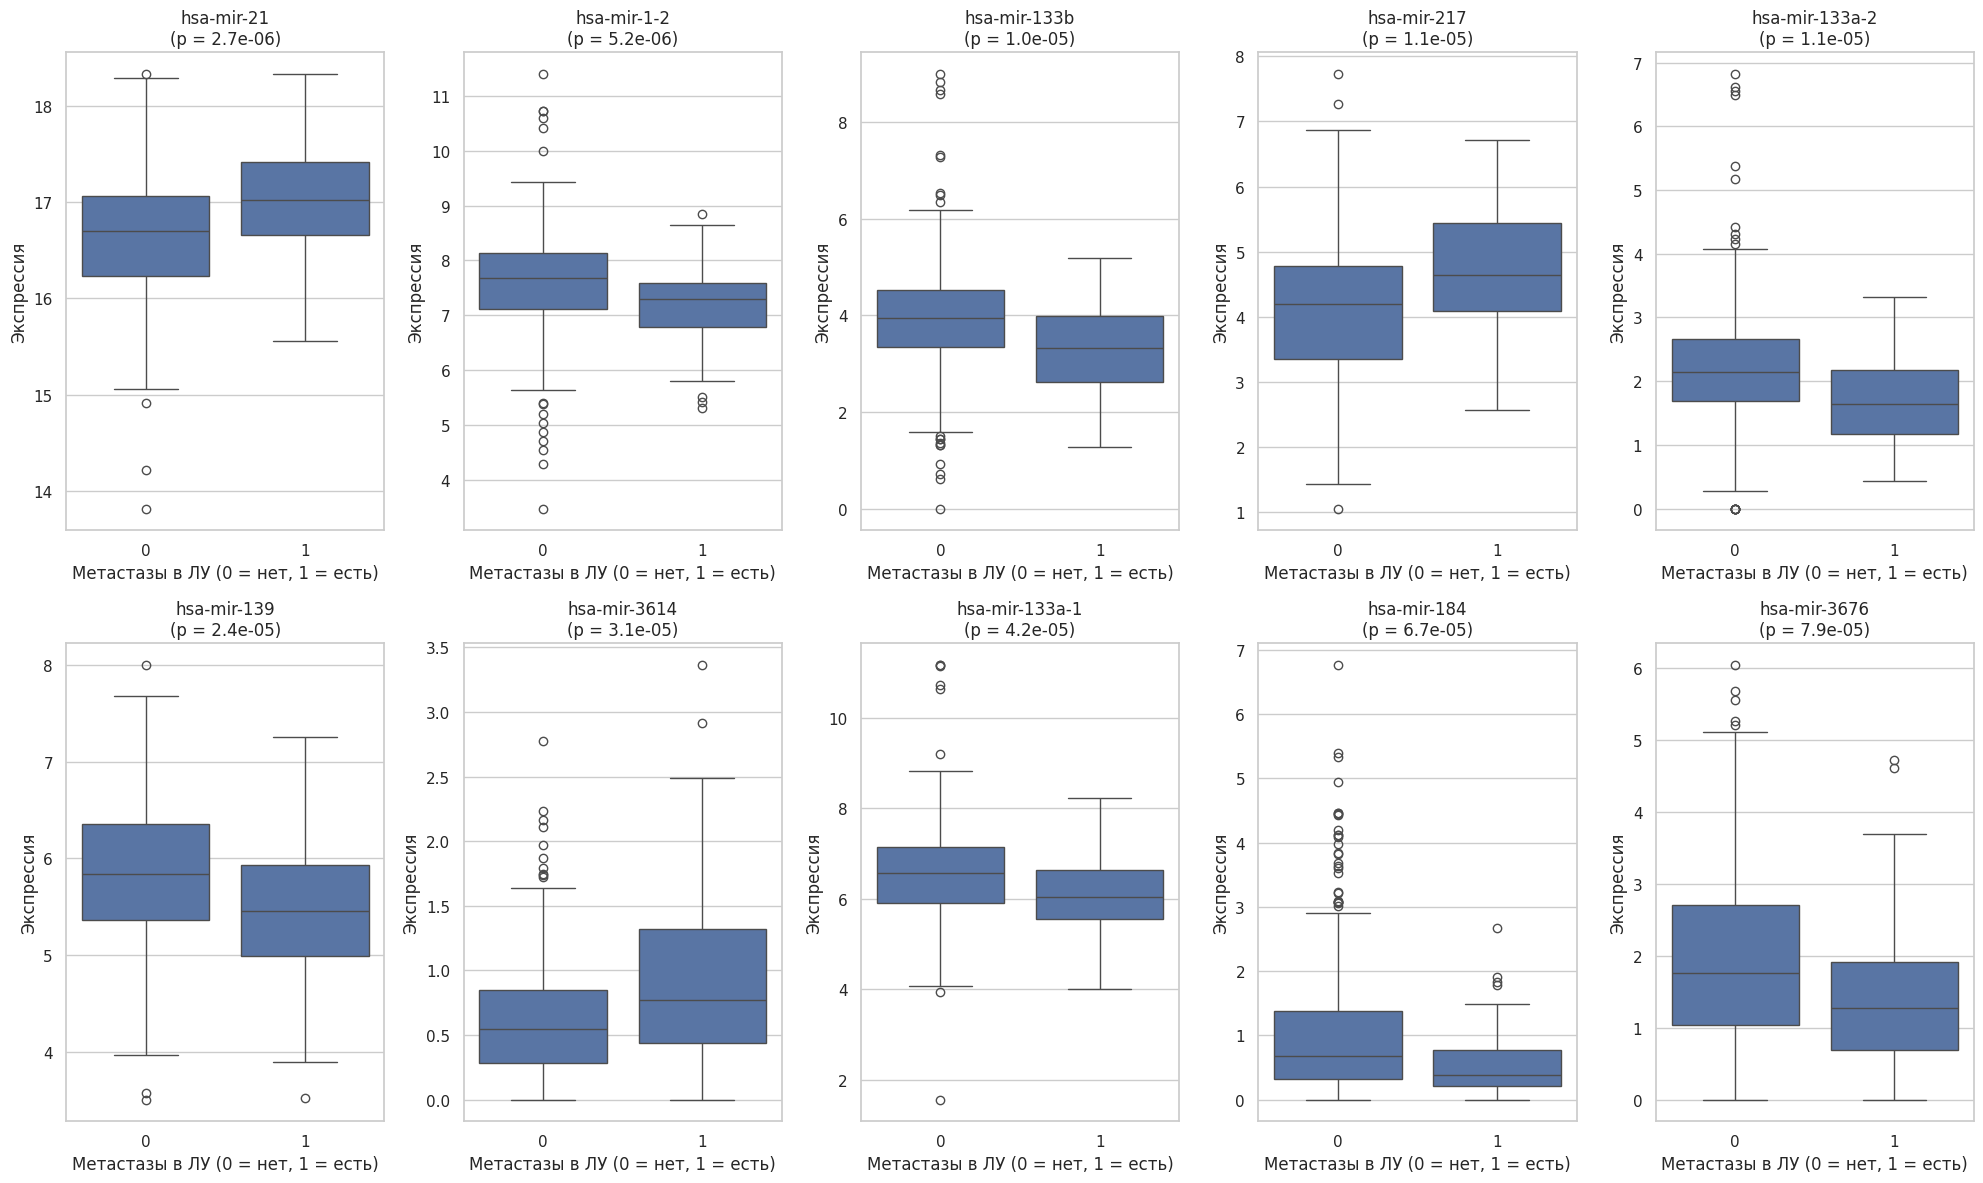

In [52]:
# Транспонирование клинических данных
clinical_df_t = clinical_df.set_index("attrib_name").T
clinical_df_t["pathology_N_stage"] = clinical_df_t["pathology_N_stage"].str.lower()
clinical_df_t["lymph_metastasis"] = clinical_df_t["pathology_N_stage"].map({"n0": 0, "n1": 1})
clinical_df_t = clinical_df_t.dropna(subset=["lymph_metastasis"])
clinical_df_t["lymph_metastasis"] = clinical_df_t["lymph_metastasis"].astype(int)

# Совмещение с miRNA
common_patients = set(clinical_df_t.index).intersection(mirna_df.columns[1:])
mirna_filtered = mirna_df[["attrib_name"] + list(common_patients)].set_index("attrib_name").T
mirna_filtered["lymph_metastasis"] = clinical_df_t.loc[mirna_filtered.index, "lymph_metastasis"]

# Анализ Mann-Whitney
X = mirna_filtered.drop(columns="lymph_metastasis")
y = mirna_filtered["lymph_metastasis"]
results = []

for mirna in X.columns:
    group0 = X[y == 0][mirna]
    group1 = X[y == 1][mirna]
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    results.append((mirna, p))

# Топ-10 значимых miRNA
top_mirnas = sorted(results, key=lambda x: x[1])[:10]

# Построение boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(20, 12))

for i, (mirna, pval) in enumerate(top_mirnas, 1):
    plt.subplot(2, 5, i)
    sns.boxplot(x=mirna_filtered["lymph_metastasis"], y=mirna_filtered[mirna])
    plt.title(f"{mirna}\n(p = {pval:.1e})")
    plt.xlabel("Метастазы в ЛУ (0 = нет, 1 = есть)")
    plt.ylabel("Экспрессия")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'PC2')

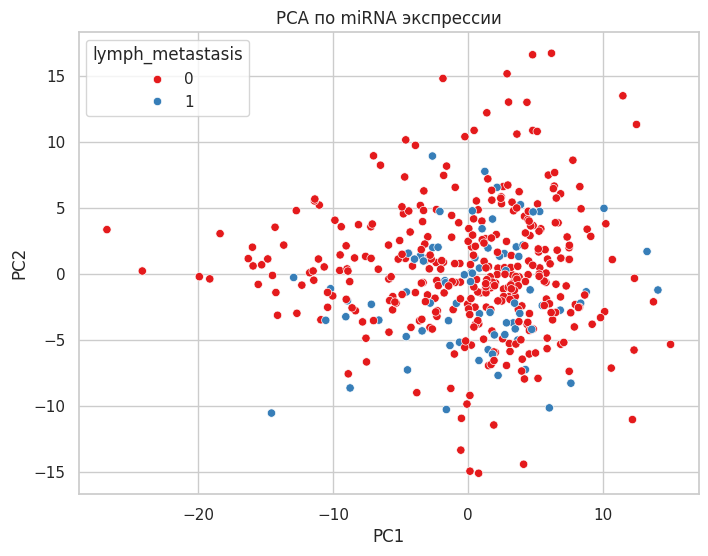

In [54]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
components = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=y, palette="Set1")
plt.title("PCA по miRNA экспрессии")
plt.xlabel("PC1")
plt.ylabel("PC2")


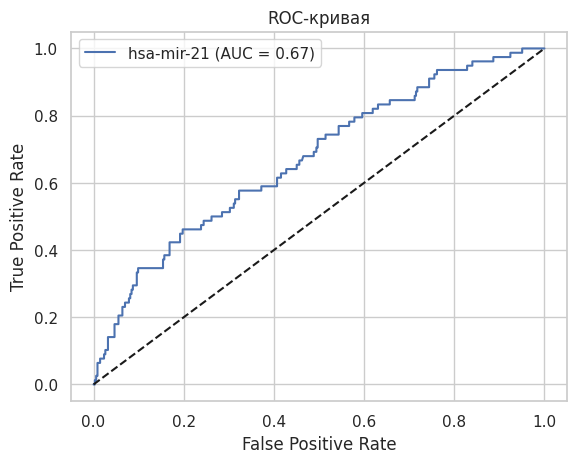

In [55]:
from sklearn.metrics import roc_curve, auc

mirna_name = "hsa-mir-21"
fpr, tpr, _ = roc_curve(y, X[mirna_name])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'{mirna_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()


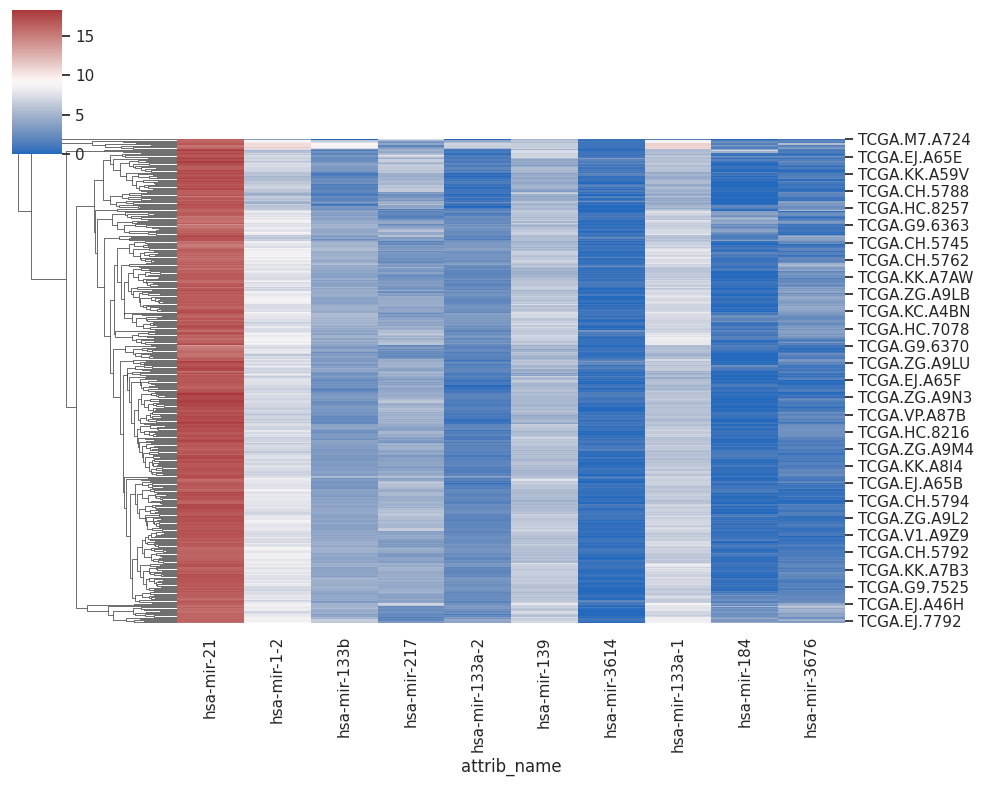

In [56]:
import seaborn as sns

top_mirna_names = [m[0] for m in top_mirnas]
heat_data = mirna_filtered[top_mirna_names].copy()
heat_data["metastasis"] = y
heat_data = heat_data.sort_values("metastasis")

sns.clustermap(heat_data[top_mirna_names], cmap="vlag", figsize=(10, 8), col_cluster=False)
